# tenseal-inference results check

In [1]:
import numpy as np
import onnx
import onnxruntime
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision import datasets

In [2]:
train_data = datasets.MNIST('data', train=True, download=False)
test_data = datasets.MNIST('data', train=False, download=False)

## plot image

label: 0


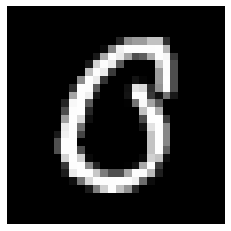

In [15]:
# plot image
def mnist_plt(img):
    if len(img) == 2:
        label = img[1]
        img = img[0]
        print(f"label: {label}")
        
    img = np.matrix(img)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.show()

mnist_plt(train_data[234])

## save image pngs

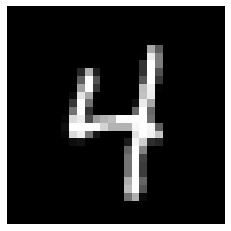

In [9]:
# save png of image
def save_png(index, path, test=True):
    if test:
        data = test_data[index]
        dataset = "test"
    else:
        data = train_data[index]
        dataset = "train"
        
    label = data[1]
    img = np.matrix(data[0])
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.savefig(f"{path}/{dataset}{index}.png", bbox_inches='tight', pad_inches=0.0)

for i in range(20):
    save_png(i, "./pngs", test=True)

## save input data as .npy for tenseal-inference

In [11]:
def save_npy(index, path, test=True):
    
    if test:
        data = test_data[index]
        dataset = "test"
    else:
        data = train_data[index]
        dataset = "train"
        
    label = data[1]
    x = np.array(data[0], dtype=np.float32) / 255
    
    with open(f"{path}/{dataset}{index}.npy", 'wb') as f:
        np.save(f,x.reshape(1,1,28,28))
    
for i in range(3):
    save_npy(i, ".", test=True)

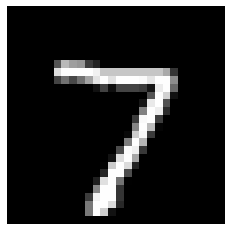

In [16]:
x = np.load("./test0.npy")
mnist_plt(x)

## perform cleartext inference (with onnxruntime) and compare to tenseal-inference result

In [70]:
def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def comparison(model_path, x, tenseal_result_path):
    mnist_plt(x)
    model = onnx.load(model_path)
    session = onnxruntime.InferenceSession(model_path)
    
    y = session.run(None, {model.graph.input[0].name: x})[0][0]
    
    sy = softmax(y)
    
    print(f"cleartext onnxruntime: {np.argmax(y)}")
    for i,yi in enumerate(y):
        print(f"{i} {yi:+10.6f} {sy[i]:.4f}")
    print()

    ## tenseal-inference result
    with open(tenseal_result_path, 'rb') as f:
        a = np.load(f)

    sa = softmax(a)
        
    print(f"tenseal-inference: {np.argmax(a)}")
    for i,ai in enumerate(a):
        print(i, f"{ai:+#10.6f} {sa[i]:.4f}")
    print()

    plt.bar(np.arange(10)-0.2, y, width=.4, label="clear")
    plt.bar(np.arange(10)+0.2, a, width=.4, label="tenseal")
    plt.grid()
    plt.legend()
    plt.show()

In [71]:
model_path = "C:/workspace/tenseal-inference/models/mnist.onnx"

Correct result: 7


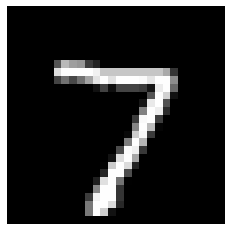

cleartext onnxruntime: 7
0 -10.768473 0.0000
1  -1.987037 0.0000
2  +2.285277 0.0000
3  +4.659378 0.0000
4  -7.801314 0.0000
5  -7.204075 0.0000
6 -10.069156 0.0000
7 +16.536650 1.0000
8  +1.277375 0.0000
9  +5.000919 0.0000

tenseal-inference: 7
0 -10.600073 0.0000
1  -1.414617 0.0000
2  -0.260015 0.0000
3  +3.864179 0.0002
4  -4.374910 0.0000
5  -7.257142 0.0000
6  -8.796747 0.0000
7 +12.578191 0.9929
8  -0.358842 0.0000
9  +7.616599 0.0070



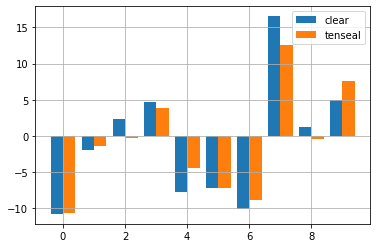

In [72]:
index = 0

data = test_data[index]
x = np.array(data[0], dtype=np.float32).reshape(1,1,28,28) / 255
tenseal_result_path = f"../tenseal-inference/tmp/poster/result{index}.npy"

print(f"Correct result: {data[1]}")
comparison(model_path, x, tenseal_result_path)

## Poster Data

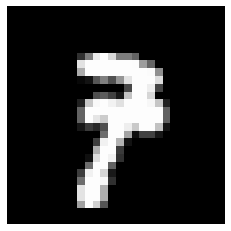

cleartext onnxruntime: 7
0  -5.412620 0.0000
1  -4.523306 0.0000
2  -6.736612 0.0000
3  +2.878737 0.0000
4  +1.270121 0.0000
5  -8.465101 0.0000
6 -24.186255 0.0000
7 +21.109985 0.9998
8  +5.163683 0.0000
9 +12.567447 0.0002

tenseal-inference: 9
0  -3.502441 0.0000
1  -4.096843 0.0000
2 -13.056243 0.0000
3  -2.152235 0.0000
4  +8.603255 0.0002
5  -7.455953 0.0000
6 -19.784997 0.0000
7 +14.167103 0.0556
8  +2.520342 0.0000
9 +16.999002 0.9442



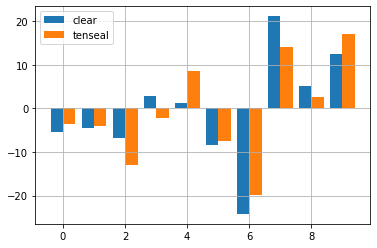

In [74]:
## LeNet5 von David (mit square activation)
index = 234

model_path = "C:/workspace/tenseal-inference/models/mnist.onnx"

x = np.load(f'C:/workspace/tenseal-inference/tmp/mnist_28x28_data/{index}.npy')

tenseal_result_path = f"../tenseal-inference/tmp/mnist_28x28/result/{index}.npy"

comparison(model_path, x, tenseal_result_path)

# commands

In [27]:
index_list = [0,1,7,5,234]

for i in index_list:
    print(f"tenseal_inference encrypt -k tmp/poster/key -i tmp/mnist_28x28_data/{i}.npy -o tmp/mnist_28x28/ct/{i}")

tenseal_inference encrypt -k tmp/poster/key -i tmp/mnist_28x28_data/0.npy -o tmp/mnist_28x28/ct/0
tenseal_inference encrypt -k tmp/poster/key -i tmp/mnist_28x28_data/1.npy -o tmp/mnist_28x28/ct/1
tenseal_inference encrypt -k tmp/poster/key -i tmp/mnist_28x28_data/7.npy -o tmp/mnist_28x28/ct/7
tenseal_inference encrypt -k tmp/poster/key -i tmp/mnist_28x28_data/5.npy -o tmp/mnist_28x28/ct/5
tenseal_inference encrypt -k tmp/poster/key -i tmp/mnist_28x28_data/234.npy -o tmp/mnist_28x28/ct/234


In [30]:
for i in index_list:
    print(f"tenseal_inference inference -m models/mnist.onnx -k tmp/poster/key -i tmp/mnist_28x28/ct/{i} -o tmp/mnist_28x28/ct_result/{i}")

tenseal_inference inference -m models/mnist.onnx -k tmp/poster/key -i tmp/mnist_28x28/ct/0 -o tmp/mnist_28x28/ct_result/0
tenseal_inference inference -m models/mnist.onnx -k tmp/poster/key -i tmp/mnist_28x28/ct/1 -o tmp/mnist_28x28/ct_result/1
tenseal_inference inference -m models/mnist.onnx -k tmp/poster/key -i tmp/mnist_28x28/ct/7 -o tmp/mnist_28x28/ct_result/7
tenseal_inference inference -m models/mnist.onnx -k tmp/poster/key -i tmp/mnist_28x28/ct/5 -o tmp/mnist_28x28/ct_result/5
tenseal_inference inference -m models/mnist.onnx -k tmp/poster/key -i tmp/mnist_28x28/ct/234 -o tmp/mnist_28x28/ct_result/234


In [32]:
for i in index_list:
    print(f"tenseal_inference decrypt -k tmp/poster/key -i tmp/mnist_28x28/ct_result/{i} -o tmp/mnist_28x28/result/{i}")

tenseal_inference decrypt -k tmp/poster/key -i tmp/mnist_28x28/ct_result/0 -o tmp/mnist_28x28/result/0
tenseal_inference decrypt -k tmp/poster/key -i tmp/mnist_28x28/ct_result/1 -o tmp/mnist_28x28/result/1
tenseal_inference decrypt -k tmp/poster/key -i tmp/mnist_28x28/ct_result/7 -o tmp/mnist_28x28/result/7
tenseal_inference decrypt -k tmp/poster/key -i tmp/mnist_28x28/ct_result/5 -o tmp/mnist_28x28/result/5
tenseal_inference decrypt -k tmp/poster/key -i tmp/mnist_28x28/ct_result/234 -o tmp/mnist_28x28/result/234
